In [2]:
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

## 1: Import Raw Data and Oil Price Treatment

In [3]:
brent_monthly = pd.read_csv('OIL PRICES/data/brent-monthly_csv.csv')
eu_economy = pd.read_csv('EU27 Economy/namq_10_gdp__custom_1561076_page_linear.csv')
brent_monthly

,Date,Price
0,1987-05-15,18.58
1,1987-06-15,18.86
2,1987-07-15,19.86
3,1987-08-15,18.98
4,1987-09-15,18.31
...,...,...
409,2021-06-15,73.16
410,2021-07-15,75.17
411,2021-08-15,70.75
412,2021-09-15,74.49


In [4]:
brent_monthly['Date'] = pd.to_datetime(brent_monthly['Date'])
brent_quarterly = brent_monthly.groupby(pd.PeriodIndex(brent_monthly['Date'], freq='Q')).Price.mean()
brent_quarterly = brent_quarterly.to_frame(name='brent_price_dollars')
brent_quarterly['ln_brent_dollars'] = np.log(brent_quarterly.brent_price_dollars)
brent_quarterly.drop(['brent_price_dollars'], axis=1, inplace=True)
brent_quarterly

,ln_brent_dollars
Date,
1987Q2,2.929592
1987Q3,2.947067
1987Q4,2.882750
1988Q1,2.755993
1988Q2,2.781920
...,...
2020Q4,3.790759
2021Q1,4.107919
2021Q2,4.231688


## 2: EU 27 GDP Cleaning

In [33]:
eu_gdp_market_price = eu_economy[eu_economy['na_item'] == 'B1GQ']
eu_gdp_market_price = eu_gdp_market_price[['TIME_PERIOD', 'OBS_VALUE']]
eu_gdp_market_price.rename(columns={'TIME_PERIOD':'Date', 'OBS_VALUE' : 'eu_gdp_market_price'}, inplace=True)
eu_gdp_market_price.Date = pd.to_datetime(eu_gdp_market_price.Date)
eu_gdp_market_price.Date = pd.PeriodIndex(eu_gdp_market_price['Date'], freq='Q')
eu_gdp_market_price.set_index(['Date'], inplace=True)
gdp_diffed = eu_gdp_market_price.diff()
gdp_diffed.dropna(inplace=True)
#eu_gdp_market_price

#### Intermediate Dataset to combine Brent & EU GDP, on which further columns will be joined:

In [34]:
eu_gdp_and_brent = gdp_diffed.join(brent_quarterly, how='left', sort=True)
eu_gdp_and_brent['gdp_billion_euros'] = eu_gdp_and_brent.eu_gdp_market_price / 1000
eu_gdp_and_brent.drop(['eu_gdp_market_price'], axis=1, inplace=True)
eu_gdp_and_brent

,ln_brent_dollars,gdp_billion_euros
Date,,
1995Q2,2.896096,18.4702
1995Q3,2.786040,27.3507
1995Q4,2.831251,18.9249
1996Q1,2.921368,17.5180
1996Q2,2.970585,20.4189
...,...,...
2020Q2,3.379065,-365.2129
2020Q3,3.760347,342.0730
2020Q4,3.790759,19.2861


## 3: Gross Capital Formation Treatment & Cleaning

In [35]:
gross_cap_formation = eu_economy[eu_economy['na_item'] == 'P5G']
gross_cap_formation = gross_cap_formation[['TIME_PERIOD', 'OBS_VALUE']]
gross_cap_formation.rename(columns={'TIME_PERIOD':'Date', 'OBS_VALUE' : 'gross_cap_formation'}, inplace=True)
gross_cap_formation.Date = pd.to_datetime(gross_cap_formation.Date)
gross_cap_formation.Date = pd.PeriodIndex(gross_cap_formation['Date'], freq='Q')
gross_cap_formation.set_index(['Date'], inplace=True)
cap_formation_diff = gross_cap_formation.diff()
cap_formation_diff.dropna(inplace=True)

## 4: Wages & Salaries Treatment & Cleaning

In [36]:
wages_and_sal = eu_economy[eu_economy['na_item'] == 'D11']
wages_and_sal = wages_and_sal[['TIME_PERIOD', 'OBS_VALUE']]
wages_and_sal.rename(columns={'TIME_PERIOD':'Date', 'OBS_VALUE' : 'wages_and_sal'}, inplace=True)
wages_and_sal.Date = pd.to_datetime(wages_and_sal.Date)
wages_and_sal.Date = pd.PeriodIndex(wages_and_sal['Date'], freq='Q')
wages_and_sal.set_index(['Date'], inplace=True)
wages_diff = wages_and_sal.diff()
wages_diff.dropna(inplace=True)

## XX: Joining of all parts to make the Main DataFrame

In [37]:
DATA = eu_gdp_and_brent.join(cap_formation_diff, how='left', sort=True)
DATA = DATA.join(wages_diff, how='left', sort=True)
DATA

,ln_brent_dollars,gdp_billion_euros,gross_cap_formation,wages_and_sal
Date,,,,
1995Q2,2.896096,18.4702,3067.9,7558.5
1995Q3,2.786040,27.3507,10708.3,7100.6
1995Q4,2.831251,18.9249,1483.3,10724.4
1996Q1,2.921368,17.5180,-5590.5,3415.0
1996Q2,2.970585,20.4189,5325.8,4921.1
...,...,...,...,...
2020Q2,3.379065,-365.2129,-159743.0,-103724.4
2020Q3,3.760347,342.0730,50477.0,91450.4
2020Q4,3.790759,19.2861,44593.0,11940.3


In [38]:
DATA['newdate'] = DATA.index.to_timestamp()
DATA.set_index(['newdate'], inplace=True)
DATA

,ln_brent_dollars,gdp_billion_euros,gross_cap_formation,wages_and_sal
newdate,,,,
1995-04-01,2.896096,18.4702,3067.9,7558.5
1995-07-01,2.786040,27.3507,10708.3,7100.6
1995-10-01,2.831251,18.9249,1483.3,10724.4
1996-01-01,2.921368,17.5180,-5590.5,3415.0
1996-04-01,2.970585,20.4189,5325.8,4921.1
...,...,...,...,...
2020-04-01,3.379065,-365.2129,-159743.0,-103724.4
2020-07-01,3.760347,342.0730,50477.0,91450.4
2020-10-01,3.790759,19.2861,44593.0,11940.3


## Visualizing the Time Series

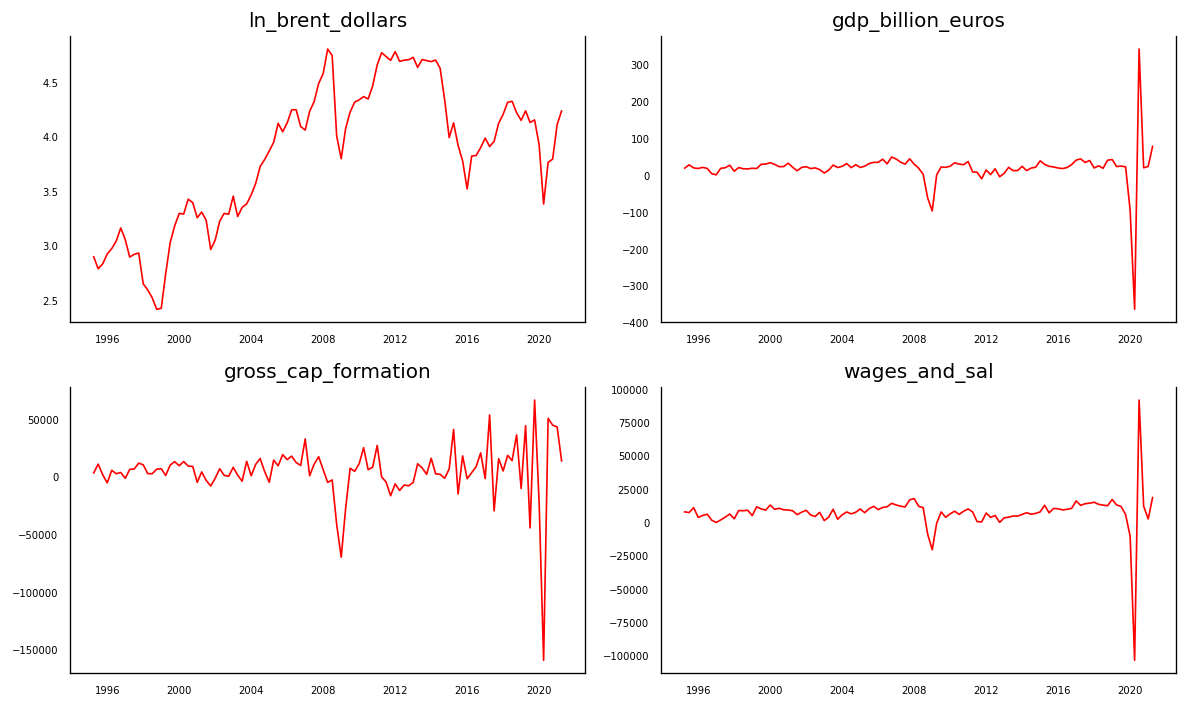

In [39]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6)) 
for i, ax in enumerate(axes.flatten()):
    data = DATA[DATA.columns[i]]
    ax.plot(data, color='red', linewidth=1) # Decorations
    ax.set_title(DATA.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6, width=3)
    
plt.tight_layout();

## Granger's Causality Test

In [43]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=2
test ='ssr_chi2test'
def grangers_causation_matrix(df, variables, test='ssr_chi2test', verbose=False):
    
    """
    Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(df[[r, c]], maxlag=maxlag, verbose=False)
            p_values =[round(test_result[i+1][0][test][1],4) for i in range(maxlag)] 
            if verbose:
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c]= min_p_value
    df.columns =[var +'_x'for var in variables]
    df.index =[var +'_y'for var in variables]
    return df

grangers_causation_matrix(DATA, variables = ['ln_brent_dollars', 'gdp_billion_euros', 'gross_cap_formation',
       'wages_and_sal'])

ValueError: Insufficient observations. Maximum allowable lag is 0

## Stationarity tests

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'])

# ADF Test
result = adfuller(df.value.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

In [ ]:
# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f'% result[0])
print('p-value: %f'% result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

In [ ]:
result = adfuller(DATA.gdp_billion_euros.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

In [ ]:
# KPSS Test
result = kpss(DATA.gdp_billion_euros.values, regression='c')
print('\nKPSS Statistic: %f'% result[0])
print('p-value: %f'% result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')